In [1]:
from pyspark.sql import SparkSession
allocated_memory = 18 * 0.75

# create a SparkSession
spark = SparkSession.builder.appName("ReadJSON")\
.config("spark.executor.memory", "6g") \
.master("local[*]")  \
.config("spark.driver.memory", "4g") \
.config("spark.network.timeout", "800s")\
.config("spark.executor.heartbeatInterval", "200s")\
.config("spark.executor.extraJavaOptions", "-XX:+UseG1GC")\
.config("spark.driver.extraJavaOptions", "-XX:+UseG1GC")\
.config("spark.memory.fraction", "0.8") \
.config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.3.3")\
.getOrCreate()

# YOUR FILE PATH MAY BE DIFFERENT, PLEASE ADJUST ACCORDINGLY
json_training_file_path ="../combined_train_data_chunked_10mb_latest.json"

:: loading settings :: url = jar:file:/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/soniasusanto/.ivy2/cache
The jars for the packages stored in: /Users/soniasusanto/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-47f41d5e-0073-491b-ba55-26ef4d8322de;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.3.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in local-m2-cache
	found org.apache.httpcomponents#httpclient;4.5.13 in local-m2-cache
	found org.apache.httpcomponents#httpcore;4.4.13 in local-m2-cache
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazona

In [2]:
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType

targetUDF = F.udf(lambda x: 1 if x >= 4.0 else 0, IntegerType())

In [3]:
from nltk.stem.porter import PorterStemmer
from pyspark import keyword_only
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param


class PorterStemming(Transformer, HasInputCol, HasOutputCol):
    """
    PosterStemming class using the NLTK Porter Stemmer

    This comes from https://stackoverflow.com/questions/32331848/create-a-custom-transformer-in-pyspark-ml
    Adapted to work with the Porter Stemmer from NLTK.
    """

    @keyword_only
    def __init__(self,
                 inputCol  : str = None,
                 outputCol : str = None,
                 min_size  : int = None):
        """
        Constructor takes in the input column name, output column name,
        plus the minimum legnth of a token (min_size)
        """
        # call Transformer classes constructor since were extending it.
        super(Transformer, self).__init__()

        # set Parameter objects minimum token size
        self.min_size = Param(self, "min_size", "")
        self._setDefault(min_size=0)

        # set the input keywork arguments
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

        # initialize Stemmer object
        self.stemmer  = PorterStemmer()


    @keyword_only
    def setParams(self,
                  inputCol  : str = None,
                  outputCol : str = None,
                  min_size  : int = None
      ) -> None:
        """
        Function to set the keyword arguemnts
        """
        kwargs = self._input_kwargs
        return self._set(**kwargs)


    def _stem_func(self, words  : list) -> list:
        """
        Stemmer function call that performs stemming on a
        list of tokens in words and returns a list of tokens
        that have meet the minimum length requiremnt.
        """
        # We need a way to get min_size and cannot access it
        # with self.min_size
        min_size       = self.getMinSize()

        # stem that actual tokens by applying
        # self.stemmer.stem function to each token in
        # the words list
        stemmed_words  = map(self.stemmer.stem, words)

        # now create the new list of tokens from
        # stemmed_words by filtering out those
        # that are not of legnth > min_size
        filtered_words = filter(lambda x: len(x) > min_size, stemmed_words)

        return list(filtered_words)

    def _transform(self, df: DataFrame) -> DataFrame:
        """
        Transform function is the method that is called in the
        MLPipleline.  We have to override this function for our own use
        and have it call the _stem_func.

        Notice how it takes in a type DataFrame and returns type Dataframe
        """
        # Get the names of the input and output columns to use
        out_col       = self.getOutputCol()
        in_col        = self.getInputCol()

        # create the stemming function UDF by wrapping the stemmer
        # method function
        stem_func_udf = F.udf(self._stem_func, ArrayType(StringType()))

        # now apply that UDF to the column in the dataframe to return
        # a new column that has the same list of words after being stemmed
        df2           = df.withColumn(out_col, stem_func_udf(df[in_col]))

        return df2


    def setMinSize(self,value):
        """
        This method sets the minimum size value
        for the _paramMap dictionary.
        """
        self._paramMap[self.min_size] = value
        return self

    def getMinSize(self) -> int:
        """
        This method uses the parent classes (Transformer)
        .getOrDefault method to get the minimum
        size of a token.
        """
        return self.getOrDefault(self.min_size)

In [4]:
json_objects = []
from pyspark.sql.types import StructType, StructField, StringType, FloatType, BooleanType, IntegerType
#"reviewerID": "A8WEXFRWX1ZHH",
# "asin": "0209688726",
# "style": {"Color:": " AC"},
# "reviewerName": "Goldengate",
# Define the schema
schema = StructType([
    StructField("overall", FloatType(), True),
    StructField("verified", BooleanType(), True),
    StructField("reviewTime", StringType(), True),
    StructField("reviewerID", StringType(), True),
    StructField("asin", StringType(), True),
    StructField("style", StructType([StructField("Color:", StringType(), True)]), True),
    StructField("reviewerName", StringType(), True),
    StructField("reviewText", StringType(), True),
    StructField("unixReviewTime", IntegerType(), True)

])

def pre_process(chunk, run):
    if run == 0:
        print("Processing chunk")
        df = spark.createDataFrame(json_objects, schema=schema)
        print('Showing original df')
        df.show(20)
        reduced_df = df.select("overall", "reviewerID", "asin", "reviewText")
        print('Showing a subset of relevant columns from original df')
        print('Count:', reduced_df.count())
        reduced_df.show(20)
        unique_df = reduced_df.dropDuplicates(["reviewerID", "asin"])
        print('Showing df after dropping duplicates')
        print('Count:', unique_df.count())
        unique_df.show(20)
        unique_df = unique_df.filter(unique_df.reviewText.isNotNull())
        print('Showing df after removing nulls')
        print('Count:', unique_df.count())
        unique_df.show(20)
        df_sentiment = unique_df.withColumn("sentiment", targetUDF(unique_df["overall"]))
        print('Showing df after adding sentiment column')
        df_sentiment.show(20)
    else:
        df = spark.createDataFrame(json_objects, schema=schema)
        reduced_df = df.select("overall", "reviewerID", "asin", "reviewText")
        unique_df = reduced_df.dropDuplicates(["reviewerID", "asin"])
        unique_df = unique_df.filter(unique_df.reviewText.isNotNull())
        df_sentiment = unique_df.withColumn("sentiment", targetUDF(unique_df["overall"]))
    return df_sentiment

In [5]:
# Building the pipeline for nlp transformers
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import Tokenizer, DocumentAssembler, StopWordsCleaner, Normalizer

def get_nlp_pipeline():
    documentAssembler = DocumentAssembler()\
        .setInputCol("reviewText")\
        .setOutputCol("document")

    stopwords_cleaner = StopWordsCleaner()\
        .setInputCols("token")\
        .setOutputCol("cleanTokens")\
        .setCaseSensitive(False)

    tokenizer = Tokenizer() \
        .setInputCols(["document"]) \
        .setOutputCol("token")

    normalizer = Normalizer() \
        .setInputCols(["token"]) \
        .setOutputCol("normalized")\
        .setLowercase(True)\
        .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])


    nlpPipeline = Pipeline(stages=[
        documentAssembler,
        tokenizer,
        stopwords_cleaner
    ])

    return nlpPipeline

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import NGram, HashingTF, IDF, Tokenizer as MLTokenizer
from pyspark.ml.classification import LogisticRegression

bigram = NGram(inputCol="stemmed", outputCol="bigrams", n=2)
tf5   = HashingTF(inputCol="bigrams", outputCol="rawFeatures", numFeatures=2e5)
# create tokens from reviews
tk = MLTokenizer(inputCol= "reviewText", outputCol = "tokens")
stem_pipeline = PorterStemming(inputCol="token", outputCol="stemmed")
# create tf-idf for each of the tokens
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=2.0)
# create basic logistic regression model
lr = LogisticRegression(maxIter=20)

bigram_pipeline  = Pipeline(stages= [tk, bigram, tf5, idf, lr])

In [7]:

import sys
import json
import os

from pyspark.ml.pipeline import PipelineModel

def transform_chunk(df, run):
    nlpPipeline = get_nlp_pipeline()
    tokenized_df = nlpPipeline.fit(df).transform(df)
    if run == 0:
        print('Showing tokenized dataframe')
        tokenized_df.show(20)
    df6_train = tokenized_df.where(F.size(F.col("cleanTokens")) > 0)
    if run == 0:
        print('Showing processed tokenized dataframe')
        tokenized_df.show(20)
    df_train_for_model = df6_train.select("reviewText","sentiment", "cleanTokens.result").withColumnRenamed("sentiment", "label").withColumnRenamed("result", "token")
    return df_train_for_model

# Define the maximum file size in bytes (10MB)
max_file_size = 10 * 1024 * 1024

json_objects = []
run = 0
# Read the file line by line until the maximum file size is reached
with open(json_training_file_path, 'r') as file:
    total_size = 0
    for line in file:
        # Calculate the size of the current line
        line_size = sys.getsizeof(line)

        # If adding the current line exceeds the maximum file size, stop reading
        if total_size + line_size >= max_file_size:
            print('Begin preprocessing')
            # Create a DataFrame from the list of JSON objects
            df = pre_process(json_objects, run)
            # Print only one the first run
            if run == 0:
                print("Show preprocessed chunk:")
                df.show(20)
            df_train = transform_chunk(df, run)
            if run == 0:
                print("Show transformed chunk:")
                df_train.show(20)
            print("Run %d" % run)
            train_stem = stem_pipeline.transform(df_train)\
                          .where(F.size(F.col("stemmed")) >= 1)
            if os.path.exists('bigram_pipeline_model'):
                loaded_model = PipelineModel.load('bigram_pipeline_model')
                stages_steps = loaded_model.stages
                updated_model = Pipeline(stages = stages_steps).fit(train_stem)
            else:
                updated_model = bigram_pipeline.fit(train_stem)

            updated_model.write().overwrite().save('bigram_pipeline_model')
            run += 1
            print('Model saved for current chunk')
            del df
            del df_train
            json_objects = []
            total_size = 0
        # Otherwise, add the line to the list of JSON objects
        json_objects.append(json.loads(line))
        total_size += line_size

Begin preprocessing
Processing chunk
Showing original df


+-------+--------+-----------+--------------+----------+------+--------------------+--------------------+--------------+
|overall|verified| reviewTime|    reviewerID|      asin| style|        reviewerName|          reviewText|unixReviewTime|
+-------+--------+-----------+--------------+----------+------+--------------------+--------------------+--------------+
|    5.0|    true| 04 5, 2016|A1274GG1EB2JLJ|0486427706|{NULL}|         barbara ann|The pictures are ...|    1459814400|
|    5.0|    true|02 13, 2016|A30X5EGBYAZQQK|0486427706|{NULL}|            Samantha|I absolutely love...|    1455321600|
|    5.0|    true|12 10, 2015|A3U6UNXLAUY6ZV|0486427706|{NULL}|         CP in Texas|          I love it!|    1449705600|
|    5.0|    true|10 26, 2015|A1SAJF5SNM6WJS|0486427706|{NULL}|         LOIS LABIER|MY HUSBAND LOVED ...|    1445817600|
|    4.0|    true|09 15, 2015| AHJWO3SI0S0OR|0486427706|{NULL}|      Saundra Hatley|                cool|    1442275200|
|    5.0|    true|05 24, 2015| A

24/04/29 21:41:28 WARN TaskSetManager: Stage 1 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


Count: 17665
+-------+--------------+----------+--------------------+
|overall|    reviewerID|      asin|          reviewText|
+-------+--------------+----------+--------------------+
|    5.0|A1274GG1EB2JLJ|0486427706|The pictures are ...|
|    5.0|A30X5EGBYAZQQK|0486427706|I absolutely love...|
|    5.0|A3U6UNXLAUY6ZV|0486427706|          I love it!|
|    5.0|A1SAJF5SNM6WJS|0486427706|MY HUSBAND LOVED ...|
|    4.0| AHJWO3SI0S0OR|0486427706|                cool|
|    5.0| ALLSNTNR6N6UL|0486427706|Exactly as descri...|
|    1.0|A3O6CP5TT54LJE|0486448789|total waste of mo...|
|    5.0|A216BPGO0ZBR5N|0486448789|Nephew, age 5 lov...|
|    5.0|A3OJCR7TKQIPQM|0486448789|          Very Cute!|
|    3.0|A2DSZOLDOG70GC|0486448789|This is pretty mu...|
|    5.0|A1ZXYT6S1SZ087|0486448789|AGE APPROPIATE. G...|
|    4.0|A3K4NTIXV7Z559|0486448789|its a cute little...|
|    2.0|A3EAVL6N8Q6MOA|0486448789|They were ok but ...|
|    5.0|A15UXQOOJ0TL8K|0486448789|        Good product|
|    4.0| AI3JLLMY

24/04/29 21:41:30 WARN TaskSetManager: Stage 5 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 21:41:32 WARN TaskSetManager: Stage 11 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


Count: 17602


+-------+--------------------+----------+--------------------+
|overall|          reviewerID|      asin|          reviewText|
+-------+--------------------+----------+--------------------+
|    5.0|A0482121TDG9NDZIJPKR|B00000K3BR|havent had a chan...|
|    2.0|A0516005NLXNKCMT2YI9|B00000K3BR|I really wanted t...|
|    5.0|      A100UD67AHFODS|0975277324|There aren't enou...|
|    5.0|      A101THPNN8FBB5|B00000DMF5| Perfect! Thank you!|
|    5.0|      A1047P9FLHTDZJ|B00000IZGI|Great travel size...|
|    2.0|      A104FIKJTC7PGB|B00000J1E2|Falls into itself...|
|    5.0|      A1084SNUEXOQJY|8499004768|I have only used ...|
|    1.0|      A108TM6JIPEPIC|B00000IVZJ|This is pretty mu...|
|    4.0|      A108TYQMA932C4|1616616598|Others have cover...|
|    3.0|      A109ZTTYWCH3OS|B00000IWD9|The compact size ...|
|    5.0|      A10BFWUY7NEE9H|B00001QEAJ|                Cute|
|    5.0|      A10DB0H2NZF11E|B00000DMDJ|My son is a huge ...|
|    3.0|      A10HF288PYJ7AF|0975277324|Ticket to Ride

24/04/29 21:41:34 WARN TaskSetManager: Stage 14 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 21:41:36 WARN TaskSetManager: Stage 20 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


Count: 17599


+-------+--------------------+----------+--------------------+
|overall|          reviewerID|      asin|          reviewText|
+-------+--------------------+----------+--------------------+
|    5.0|A0482121TDG9NDZIJPKR|B00000K3BR|havent had a chan...|
|    2.0|A0516005NLXNKCMT2YI9|B00000K3BR|I really wanted t...|
|    5.0|      A100UD67AHFODS|0975277324|There aren't enou...|
|    5.0|      A101THPNN8FBB5|B00000DMF5| Perfect! Thank you!|
|    5.0|      A1047P9FLHTDZJ|B00000IZGI|Great travel size...|
|    2.0|      A104FIKJTC7PGB|B00000J1E2|Falls into itself...|
|    5.0|      A1084SNUEXOQJY|8499004768|I have only used ...|
|    1.0|      A108TM6JIPEPIC|B00000IVZJ|This is pretty mu...|
|    4.0|      A108TYQMA932C4|1616616598|Others have cover...|
|    3.0|      A109ZTTYWCH3OS|B00000IWD9|The compact size ...|
|    5.0|      A10BFWUY7NEE9H|B00001QEAJ|                Cute|
|    5.0|      A10DB0H2NZF11E|B00000DMDJ|My son is a huge ...|
|    3.0|      A10HF288PYJ7AF|0975277324|Ticket to Ride

24/04/29 21:41:38 WARN TaskSetManager: Stage 23 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 21:41:41 WARN TaskSetManager: Stage 26 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0482121TDG9NDZIJPKR|B00000K3BR|havent had a chan...|        1|
|    2.0|A0516005NLXNKCMT2YI9|B00000K3BR|I really wanted t...|        0|
|    5.0|      A100UD67AHFODS|0975277324|There aren't enou...|        1|
|    5.0|      A101THPNN8FBB5|B00000DMF5| Perfect! Thank you!|        1|
|    5.0|      A1047P9FLHTDZJ|B00000IZGI|Great travel size...|        1|
|    2.0|      A104FIKJTC7PGB|B00000J1E2|Falls into itself...|        0|
|    5.0|      A1084SNUEXOQJY|8499004768|I have only used ...|        1|
|    1.0|      A108TM6JIPEPIC|B00000IVZJ|This is pretty mu...|        0|
|    4.0|      A108TYQMA932C4|1616616598|Others have cover...|        1|
|    3.0|      A109ZTTYWCH3OS|B00000IWD9|The compact size ...|        0|
|    5.0|      A10BFWUY7NEE9H|B00001QEAJ|          

+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    5.0|A0482121TDG9NDZIJPKR|B00000K3BR|havent had a chan...|        1|
|    2.0|A0516005NLXNKCMT2YI9|B00000K3BR|I really wanted t...|        0|
|    5.0|      A100UD67AHFODS|0975277324|There aren't enou...|        1|
|    5.0|      A101THPNN8FBB5|B00000DMF5| Perfect! Thank you!|        1|
|    5.0|      A1047P9FLHTDZJ|B00000IZGI|Great travel size...|        1|
|    2.0|      A104FIKJTC7PGB|B00000J1E2|Falls into itself...|        0|
|    5.0|      A1084SNUEXOQJY|8499004768|I have only used ...|        1|
|    1.0|      A108TM6JIPEPIC|B00000IVZJ|This is pretty mu...|        0|
|    4.0|      A108TYQMA932C4|1616616598|Others have cover...|        1|
|    3.0|      A109ZTTYWCH3OS|B00000IWD9|The compact size ...|        0|
|    5.0|      A10BFWUY7NEE9H|B00001QEAJ|          

24/04/29 21:41:44 WARN TaskSetManager: Stage 29 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0482121TDG9NDZIJPKR|B00000K3BR|havent had a chan...|        1|[{document, 0, 68...|[{token, 0, 5, ha...|[{token, 0, 5, ha...|
|    2.0|A0516005NLXNKCMT2YI9|B00000K3BR|I really wanted t...|        0|[{document, 0, 10...|[{token, 0, 0, I,...|[{token, 2, 7, re...|
|    5.0|      A100UD67AHFODS|0975277324|There aren't enou...|        1|[{document, 0, 12...|[{token, 0, 4, Th...|[{token, 13, 18, ...|
|    5.0|      A101THPNN8FBB5|B00000DMF5| Perfect! Thank you!|        1|[{document, 0, 18...|[{token, 0, 6, Pe...|[{token, 0, 6, Pe...|
|    5.0|      A1047P9FLHTDZJ|B00000IZGI|Great t

24/04/29 21:41:47 WARN TaskSetManager: Stage 32 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 21:41:49 WARN TaskSetManager: Stage 35 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.


+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|overall|          reviewerID|      asin|          reviewText|sentiment|            document|               token|         cleanTokens|
+-------+--------------------+----------+--------------------+---------+--------------------+--------------------+--------------------+
|    5.0|A0482121TDG9NDZIJPKR|B00000K3BR|havent had a chan...|        1|[{document, 0, 68...|[{token, 0, 5, ha...|[{token, 0, 5, ha...|
|    2.0|A0516005NLXNKCMT2YI9|B00000K3BR|I really wanted t...|        0|[{document, 0, 10...|[{token, 0, 0, I,...|[{token, 2, 7, re...|
|    5.0|      A100UD67AHFODS|0975277324|There aren't enou...|        1|[{document, 0, 12...|[{token, 0, 4, Th...|[{token, 13, 18, ...|
|    5.0|      A101THPNN8FBB5|B00000DMF5| Perfect! Thank you!|        1|[{document, 0, 18...|[{token, 0, 6, Pe...|[{token, 0, 6, Pe...|
|    5.0|      A1047P9FLHTDZJ|B00000IZGI|Great t

+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|havent had a chan...|    1|[havent, chance, ...|
|I really wanted t...|    0|[really, wanted, ...|
|There aren't enou...|    1|[enough, adjectiv...|
| Perfect! Thank you!|    1|[Perfect, !, Than...|
|Great travel size...|    1|[Great, travel, s...|
|Falls into itself...|    0|[Falls, stay, ., ...|
|I have only used ...|    1|[used, twice, far...|
|This is pretty mu...|    0|[pretty, much, le...|
|Others have cover...|    1|[Others, covered,...|
|The compact size ...|    0|[compact, size, n...|
|                Cute|    1|              [Cute]|
|My son is a huge ...|    1|[son, huge, Curio...|
|Ticket to Ride is...|    0|[Ticket, Ride, ok...|
|This toy is easil...|    1|[toy, easily, one...|
|I really like Scr...|    1|[really, like, Sc...|
|This is a classic...|    1|[classic, never, ...|
|My grandson loves...|    1|[grandson, loves,...|


24/04/29 21:41:52 WARN TaskSetManager: Stage 38 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 21:42:28 WARN TaskSetManager: Stage 41 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 21:42:29 WARN TaskSetManager: Stage 42 contains a task of very large size (1005 KiB). The maximum recommended task size is 1000 KiB.
24/04/29 21:42:30 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/04/29 21:42:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/29 21:42:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/04/29 21:42:56 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/04/29 21:43:19 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/04/29 21:43:19 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/04/29 21:4

Model saved for current chunk
Begin preprocessing
Run 1


24/04/29 21:43:40 WARN TaskSetManager: Stage 124 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 2


24/04/29 21:43:47 WARN TaskSetManager: Stage 152 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 3


24/04/29 21:43:53 WARN TaskSetManager: Stage 180 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 4


24/04/29 21:43:59 WARN TaskSetManager: Stage 208 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 5


24/04/29 21:44:05 WARN TaskSetManager: Stage 236 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 6


24/04/29 21:44:10 WARN TaskSetManager: Stage 264 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 7


24/04/29 21:44:16 WARN TaskSetManager: Stage 292 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 8


24/04/29 21:44:22 WARN TaskSetManager: Stage 320 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 9


24/04/29 21:44:27 WARN TaskSetManager: Stage 348 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 10


24/04/29 21:44:33 WARN TaskSetManager: Stage 376 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 11


24/04/29 21:44:38 WARN TaskSetManager: Stage 404 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 12


24/04/29 21:44:44 WARN TaskSetManager: Stage 432 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 13


24/04/29 21:44:50 WARN TaskSetManager: Stage 460 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 14


24/04/29 21:44:55 WARN TaskSetManager: Stage 488 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 15


24/04/29 21:45:00 WARN TaskSetManager: Stage 516 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 16


24/04/29 21:45:06 WARN TaskSetManager: Stage 544 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 17


24/04/29 21:45:11 WARN TaskSetManager: Stage 572 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 18


24/04/29 21:45:16 WARN TaskSetManager: Stage 600 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 19


24/04/29 21:45:21 WARN TaskSetManager: Stage 628 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 20


24/04/29 21:45:27 WARN TaskSetManager: Stage 656 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 21


24/04/29 21:45:33 WARN TaskSetManager: Stage 684 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 22


24/04/29 21:45:38 WARN TaskSetManager: Stage 712 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 23


24/04/29 21:45:44 WARN TaskSetManager: Stage 740 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 24


24/04/29 21:45:49 WARN TaskSetManager: Stage 768 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 25


24/04/29 21:45:54 WARN TaskSetManager: Stage 796 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 26


24/04/29 21:45:59 WARN TaskSetManager: Stage 824 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 27


24/04/29 21:46:04 WARN TaskSetManager: Stage 852 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 28


24/04/29 21:46:09 WARN TaskSetManager: Stage 880 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 29


24/04/29 21:46:14 WARN TaskSetManager: Stage 908 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 30


24/04/29 21:46:19 WARN TaskSetManager: Stage 936 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 31


24/04/29 21:46:24 WARN TaskSetManager: Stage 964 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 32


24/04/29 21:46:29 WARN TaskSetManager: Stage 992 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 33


24/04/29 21:46:33 WARN TaskSetManager: Stage 1020 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 34


24/04/29 21:46:39 WARN TaskSetManager: Stage 1048 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 35


24/04/29 21:46:44 WARN TaskSetManager: Stage 1076 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 36


24/04/29 21:46:49 WARN TaskSetManager: Stage 1104 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 37


24/04/29 21:46:54 WARN TaskSetManager: Stage 1132 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 38


24/04/29 21:46:59 WARN TaskSetManager: Stage 1160 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 39


24/04/29 21:47:04 WARN TaskSetManager: Stage 1188 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 40


24/04/29 21:47:09 WARN TaskSetManager: Stage 1216 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 41


24/04/29 21:47:15 WARN TaskSetManager: Stage 1244 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 42


24/04/29 21:47:20 WARN TaskSetManager: Stage 1272 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 43


24/04/29 21:47:25 WARN TaskSetManager: Stage 1300 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 44


24/04/29 21:47:31 WARN TaskSetManager: Stage 1328 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 45


24/04/29 21:47:36 WARN TaskSetManager: Stage 1356 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 46


24/04/29 21:47:41 WARN TaskSetManager: Stage 1384 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 47


24/04/29 21:47:46 WARN TaskSetManager: Stage 1412 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 48


24/04/29 21:47:51 WARN TaskSetManager: Stage 1440 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 49


24/04/29 21:47:56 WARN TaskSetManager: Stage 1468 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 50


24/04/29 21:48:01 WARN TaskSetManager: Stage 1496 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 51


24/04/29 21:48:06 WARN TaskSetManager: Stage 1524 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 52


24/04/29 21:48:11 WARN TaskSetManager: Stage 1552 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 53


24/04/29 21:48:16 WARN TaskSetManager: Stage 1580 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 54


24/04/29 21:48:22 WARN TaskSetManager: Stage 1608 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 55


24/04/29 21:48:27 WARN TaskSetManager: Stage 1636 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 56


24/04/29 21:48:32 WARN TaskSetManager: Stage 1664 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 57


24/04/29 21:48:37 WARN TaskSetManager: Stage 1692 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 58


24/04/29 21:48:42 WARN TaskSetManager: Stage 1720 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 59


24/04/29 21:48:48 WARN TaskSetManager: Stage 1748 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 60


24/04/29 21:48:53 WARN TaskSetManager: Stage 1776 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 61


24/04/29 21:48:58 WARN TaskSetManager: Stage 1804 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 62


24/04/29 21:49:02 WARN TaskSetManager: Stage 1832 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 63


24/04/29 21:49:07 WARN TaskSetManager: Stage 1860 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 64


24/04/29 21:49:12 WARN TaskSetManager: Stage 1888 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 65


24/04/29 21:49:17 WARN TaskSetManager: Stage 1916 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 66


24/04/29 21:49:22 WARN TaskSetManager: Stage 1944 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 67


24/04/29 21:49:27 WARN TaskSetManager: Stage 1972 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 68


24/04/29 21:49:31 WARN TaskSetManager: Stage 2000 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 69


24/04/29 21:49:37 WARN TaskSetManager: Stage 2028 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 70


24/04/29 21:49:42 WARN TaskSetManager: Stage 2056 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 71


24/04/29 21:49:48 WARN TaskSetManager: Stage 2084 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 72


24/04/29 21:49:53 WARN TaskSetManager: Stage 2112 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 73


24/04/29 21:49:57 WARN TaskSetManager: Stage 2140 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 74


24/04/29 21:50:02 WARN TaskSetManager: Stage 2168 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 75


24/04/29 21:50:07 WARN TaskSetManager: Stage 2196 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 76


24/04/29 21:50:12 WARN TaskSetManager: Stage 2224 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 77


24/04/29 21:50:17 WARN TaskSetManager: Stage 2252 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 78


24/04/29 21:50:21 WARN TaskSetManager: Stage 2280 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 79


24/04/29 21:50:26 WARN TaskSetManager: Stage 2308 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 80


24/04/29 21:50:30 WARN TaskSetManager: Stage 2336 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 81


24/04/29 21:50:35 WARN TaskSetManager: Stage 2364 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 82


24/04/29 21:50:39 WARN TaskSetManager: Stage 2392 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 83


24/04/29 21:50:43 WARN TaskSetManager: Stage 2420 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 84


24/04/29 21:50:47 WARN TaskSetManager: Stage 2448 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 85


24/04/29 21:50:51 WARN TaskSetManager: Stage 2476 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 86


24/04/29 21:50:55 WARN TaskSetManager: Stage 2504 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 87


24/04/29 21:50:59 WARN TaskSetManager: Stage 2532 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 88


24/04/29 21:51:03 WARN TaskSetManager: Stage 2560 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 89


24/04/29 21:51:07 WARN TaskSetManager: Stage 2588 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 90


24/04/29 21:51:11 WARN TaskSetManager: Stage 2616 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 91


24/04/29 21:51:16 WARN TaskSetManager: Stage 2644 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 92


24/04/29 21:51:20 WARN TaskSetManager: Stage 2672 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 93


24/04/29 21:51:24 WARN TaskSetManager: Stage 2700 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 94


24/04/29 21:51:28 WARN TaskSetManager: Stage 2728 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 95


24/04/29 21:51:32 WARN TaskSetManager: Stage 2756 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 96


24/04/29 21:51:37 WARN TaskSetManager: Stage 2784 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 97


24/04/29 21:51:41 WARN TaskSetManager: Stage 2812 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 98


24/04/29 21:51:46 WARN TaskSetManager: Stage 2840 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 99


24/04/29 21:51:52 WARN TaskSetManager: Stage 2868 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 100


24/04/29 21:51:57 WARN TaskSetManager: Stage 2896 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 101


24/04/29 21:52:02 WARN TaskSetManager: Stage 2924 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 102


24/04/29 21:52:08 WARN TaskSetManager: Stage 2952 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 103


24/04/29 21:52:13 WARN TaskSetManager: Stage 2980 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 104


24/04/29 21:52:19 WARN TaskSetManager: Stage 3008 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 105


24/04/29 21:52:24 WARN TaskSetManager: Stage 3036 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 106


24/04/29 21:52:29 WARN TaskSetManager: Stage 3064 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 107


24/04/29 21:52:33 WARN TaskSetManager: Stage 3092 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 108


24/04/29 21:52:38 WARN TaskSetManager: Stage 3120 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 109


24/04/29 21:52:42 WARN TaskSetManager: Stage 3148 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 110


24/04/29 21:52:46 WARN TaskSetManager: Stage 3176 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 111


24/04/29 21:52:50 WARN TaskSetManager: Stage 3204 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 112


24/04/29 21:52:53 WARN TaskSetManager: Stage 3232 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 113


24/04/29 21:52:57 WARN TaskSetManager: Stage 3260 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 114


24/04/29 21:53:00 WARN TaskSetManager: Stage 3288 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 115


24/04/29 21:53:03 WARN TaskSetManager: Stage 3316 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 116


24/04/29 21:53:07 WARN TaskSetManager: Stage 3344 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 117


24/04/29 21:53:10 WARN TaskSetManager: Stage 3372 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 118


24/04/29 21:53:13 WARN TaskSetManager: Stage 3400 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 119


24/04/29 21:53:17 WARN TaskSetManager: Stage 3428 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 120


24/04/29 21:53:21 WARN TaskSetManager: Stage 3456 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 121


24/04/29 21:53:24 WARN TaskSetManager: Stage 3484 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 122


24/04/29 21:53:27 WARN TaskSetManager: Stage 3512 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 123


24/04/29 21:53:31 WARN TaskSetManager: Stage 3540 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 124


24/04/29 21:53:34 WARN TaskSetManager: Stage 3568 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 125


24/04/29 21:53:37 WARN TaskSetManager: Stage 3596 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 126


24/04/29 21:53:40 WARN TaskSetManager: Stage 3624 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 127


24/04/29 21:53:44 WARN TaskSetManager: Stage 3652 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 128


24/04/29 21:53:47 WARN TaskSetManager: Stage 3680 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 129


24/04/29 21:53:51 WARN TaskSetManager: Stage 3708 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 130


24/04/29 21:53:54 WARN TaskSetManager: Stage 3736 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 131


24/04/29 21:53:58 WARN TaskSetManager: Stage 3764 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 132


24/04/29 21:54:02 WARN TaskSetManager: Stage 3792 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 133


24/04/29 21:54:06 WARN TaskSetManager: Stage 3820 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 134


24/04/29 21:54:09 WARN TaskSetManager: Stage 3848 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 135


24/04/29 21:54:13 WARN TaskSetManager: Stage 3876 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 136


24/04/29 21:54:17 WARN TaskSetManager: Stage 3904 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 137


24/04/29 21:54:20 WARN TaskSetManager: Stage 3932 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 138


24/04/29 21:54:24 WARN TaskSetManager: Stage 3960 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 139


24/04/29 21:54:28 WARN TaskSetManager: Stage 3988 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 140


24/04/29 21:54:31 WARN TaskSetManager: Stage 4016 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 141


24/04/29 21:54:35 WARN TaskSetManager: Stage 4044 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 142


24/04/29 21:54:39 WARN TaskSetManager: Stage 4072 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 143


24/04/29 21:54:42 WARN TaskSetManager: Stage 4100 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 144


24/04/29 21:54:46 WARN TaskSetManager: Stage 4128 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 145


24/04/29 21:54:49 WARN TaskSetManager: Stage 4156 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 146


24/04/29 21:54:53 WARN TaskSetManager: Stage 4184 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 147


24/04/29 21:54:56 WARN TaskSetManager: Stage 4212 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 148


24/04/29 21:55:00 WARN TaskSetManager: Stage 4240 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 149


24/04/29 21:55:03 WARN TaskSetManager: Stage 4268 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 150


24/04/29 21:55:07 WARN TaskSetManager: Stage 4296 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 151


24/04/29 21:55:11 WARN TaskSetManager: Stage 4324 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 152


24/04/29 21:55:15 WARN TaskSetManager: Stage 4352 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 153


24/04/29 21:55:19 WARN TaskSetManager: Stage 4380 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 154


24/04/29 21:55:23 WARN TaskSetManager: Stage 4408 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 155


24/04/29 21:55:27 WARN TaskSetManager: Stage 4436 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 156


24/04/29 21:55:30 WARN TaskSetManager: Stage 4464 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 157


24/04/29 21:55:34 WARN TaskSetManager: Stage 4492 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 158


24/04/29 21:55:39 WARN TaskSetManager: Stage 4520 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 159


24/04/29 21:55:43 WARN TaskSetManager: Stage 4548 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 160


24/04/29 21:55:48 WARN TaskSetManager: Stage 4576 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 161


24/04/29 21:55:52 WARN TaskSetManager: Stage 4604 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 162


24/04/29 21:55:56 WARN TaskSetManager: Stage 4632 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 163


24/04/29 21:56:00 WARN TaskSetManager: Stage 4660 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 164


24/04/29 21:56:04 WARN TaskSetManager: Stage 4688 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 165


24/04/29 21:56:08 WARN TaskSetManager: Stage 4716 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 166


24/04/29 21:56:11 WARN TaskSetManager: Stage 4744 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 167


24/04/29 21:56:15 WARN TaskSetManager: Stage 4772 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 168


24/04/29 21:56:20 WARN TaskSetManager: Stage 4800 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 169


24/04/29 21:56:24 WARN TaskSetManager: Stage 4828 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 170


24/04/29 21:56:29 WARN TaskSetManager: Stage 4856 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 171


24/04/29 21:56:33 WARN TaskSetManager: Stage 4884 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 172


24/04/29 21:56:38 WARN TaskSetManager: Stage 4912 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 173


24/04/29 21:56:42 WARN TaskSetManager: Stage 4940 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 174


24/04/29 21:56:46 WARN TaskSetManager: Stage 4968 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 175


24/04/29 21:56:50 WARN TaskSetManager: Stage 4996 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 176


24/04/29 21:56:54 WARN TaskSetManager: Stage 5024 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 177


24/04/29 21:56:59 WARN TaskSetManager: Stage 5052 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 178


24/04/29 21:57:03 WARN TaskSetManager: Stage 5080 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 179


24/04/29 21:57:08 WARN TaskSetManager: Stage 5108 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 180


24/04/29 21:57:12 WARN TaskSetManager: Stage 5136 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 181


24/04/29 21:57:17 WARN TaskSetManager: Stage 5164 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 182


24/04/29 21:57:21 WARN TaskSetManager: Stage 5192 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 183


24/04/29 21:57:25 WARN TaskSetManager: Stage 5220 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 184


24/04/29 21:57:29 WARN TaskSetManager: Stage 5248 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 185


24/04/29 21:57:34 WARN TaskSetManager: Stage 5276 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 186


24/04/29 21:57:38 WARN TaskSetManager: Stage 5304 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 187


24/04/29 21:57:43 WARN TaskSetManager: Stage 5332 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 188


24/04/29 21:57:48 WARN TaskSetManager: Stage 5360 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 189


24/04/29 21:57:52 WARN TaskSetManager: Stage 5388 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 190


24/04/29 21:57:56 WARN TaskSetManager: Stage 5416 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 191


24/04/29 21:58:00 WARN TaskSetManager: Stage 5444 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 192


24/04/29 21:58:04 WARN TaskSetManager: Stage 5472 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 193


24/04/29 21:58:08 WARN TaskSetManager: Stage 5500 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 194


24/04/29 21:58:13 WARN TaskSetManager: Stage 5528 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 195


24/04/29 21:58:17 WARN TaskSetManager: Stage 5556 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 196


24/04/29 21:58:22 WARN TaskSetManager: Stage 5584 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 197


24/04/29 21:58:26 WARN TaskSetManager: Stage 5612 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 198


24/04/29 21:58:31 WARN TaskSetManager: Stage 5640 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 199


24/04/29 21:58:36 WARN TaskSetManager: Stage 5668 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 200


24/04/29 21:58:40 WARN TaskSetManager: Stage 5696 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 201


24/04/29 21:58:45 WARN TaskSetManager: Stage 5724 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 202


24/04/29 21:58:49 WARN TaskSetManager: Stage 5752 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 203


24/04/29 21:58:53 WARN TaskSetManager: Stage 5780 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 204


24/04/29 21:58:57 WARN TaskSetManager: Stage 5808 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 205


24/04/29 21:59:01 WARN TaskSetManager: Stage 5836 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 206


24/04/29 21:59:05 WARN TaskSetManager: Stage 5864 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 207


24/04/29 21:59:10 WARN TaskSetManager: Stage 5892 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 208


24/04/29 21:59:14 WARN TaskSetManager: Stage 5920 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 209


24/04/29 21:59:18 WARN TaskSetManager: Stage 5948 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 210


24/04/29 21:59:23 WARN TaskSetManager: Stage 5976 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 211


24/04/29 21:59:27 WARN TaskSetManager: Stage 6004 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 212


24/04/29 21:59:31 WARN TaskSetManager: Stage 6032 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 213


24/04/29 21:59:35 WARN TaskSetManager: Stage 6060 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 214


24/04/29 21:59:40 WARN TaskSetManager: Stage 6088 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 215


24/04/29 21:59:44 WARN TaskSetManager: Stage 6116 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 216


24/04/29 21:59:49 WARN TaskSetManager: Stage 6144 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 217


24/04/29 21:59:53 WARN TaskSetManager: Stage 6172 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 218


24/04/29 21:59:57 WARN TaskSetManager: Stage 6200 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 219


24/04/29 22:00:02 WARN TaskSetManager: Stage 6228 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 220


24/04/29 22:00:06 WARN TaskSetManager: Stage 6256 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 221


24/04/29 22:00:10 WARN TaskSetManager: Stage 6284 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 222


24/04/29 22:00:14 WARN TaskSetManager: Stage 6312 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 223


24/04/29 22:00:18 WARN TaskSetManager: Stage 6340 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 224


24/04/29 22:00:23 WARN TaskSetManager: Stage 6368 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 225


24/04/29 22:00:28 WARN TaskSetManager: Stage 6396 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 226


24/04/29 22:00:33 WARN TaskSetManager: Stage 6424 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 227


24/04/29 22:00:38 WARN TaskSetManager: Stage 6452 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 228


24/04/29 22:00:42 WARN TaskSetManager: Stage 6480 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 229


24/04/29 22:00:46 WARN TaskSetManager: Stage 6508 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 230


24/04/29 22:00:51 WARN TaskSetManager: Stage 6536 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 231


24/04/29 22:00:55 WARN TaskSetManager: Stage 6564 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 232


24/04/29 22:01:00 WARN TaskSetManager: Stage 6592 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 233


24/04/29 22:01:05 WARN TaskSetManager: Stage 6620 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 234


24/04/29 22:01:10 WARN TaskSetManager: Stage 6648 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 235


24/04/29 22:01:14 WARN TaskSetManager: Stage 6676 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 236


24/04/29 22:01:19 WARN TaskSetManager: Stage 6704 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 237


24/04/29 22:01:25 WARN TaskSetManager: Stage 6732 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 238


24/04/29 22:01:29 WARN TaskSetManager: Stage 6760 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 239


24/04/29 22:01:35 WARN TaskSetManager: Stage 6788 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 240


24/04/29 22:01:40 WARN TaskSetManager: Stage 6816 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 241


24/04/29 22:01:45 WARN TaskSetManager: Stage 6844 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 242


24/04/29 22:01:49 WARN TaskSetManager: Stage 6872 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 243


24/04/29 22:01:54 WARN TaskSetManager: Stage 6900 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 244


24/04/29 22:01:58 WARN TaskSetManager: Stage 6928 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 245


24/04/29 22:02:02 WARN TaskSetManager: Stage 6956 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 246


24/04/29 22:02:07 WARN TaskSetManager: Stage 6984 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 247


24/04/29 22:02:12 WARN TaskSetManager: Stage 7012 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 248


24/04/29 22:02:16 WARN TaskSetManager: Stage 7040 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 249


24/04/29 22:02:21 WARN TaskSetManager: Stage 7068 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 250


24/04/29 22:02:25 WARN TaskSetManager: Stage 7096 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 251


24/04/29 22:02:30 WARN TaskSetManager: Stage 7124 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 252


24/04/29 22:02:35 WARN TaskSetManager: Stage 7152 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 253


24/04/29 22:02:41 WARN TaskSetManager: Stage 7180 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 254


24/04/29 22:02:46 WARN TaskSetManager: Stage 7208 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 255


24/04/29 22:02:51 WARN TaskSetManager: Stage 7236 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 256


24/04/29 22:02:56 WARN TaskSetManager: Stage 7264 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 257


24/04/29 22:03:00 WARN TaskSetManager: Stage 7292 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 258


24/04/29 22:03:05 WARN TaskSetManager: Stage 7320 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 259


24/04/29 22:03:09 WARN TaskSetManager: Stage 7348 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 260


24/04/29 22:03:13 WARN TaskSetManager: Stage 7376 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 261


24/04/29 22:03:18 WARN TaskSetManager: Stage 7404 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 262


24/04/29 22:03:23 WARN TaskSetManager: Stage 7432 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 263


24/04/29 22:03:28 WARN TaskSetManager: Stage 7460 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 264


24/04/29 22:03:33 WARN TaskSetManager: Stage 7488 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 265


24/04/29 22:03:37 WARN TaskSetManager: Stage 7516 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 266


24/04/29 22:03:42 WARN TaskSetManager: Stage 7544 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 267


24/04/29 22:03:46 WARN TaskSetManager: Stage 7572 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 268


24/04/29 22:03:49 WARN TaskSetManager: Stage 7600 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 269


24/04/29 22:03:54 WARN TaskSetManager: Stage 7628 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 270


24/04/29 22:03:58 WARN TaskSetManager: Stage 7656 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 271


24/04/29 22:04:03 WARN TaskSetManager: Stage 7684 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 272


24/04/29 22:04:08 WARN TaskSetManager: Stage 7712 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 273


24/04/29 22:04:13 WARN TaskSetManager: Stage 7740 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 274


24/04/29 22:04:18 WARN TaskSetManager: Stage 7768 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 275


24/04/29 22:04:22 WARN TaskSetManager: Stage 7796 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 276


24/04/29 22:04:26 WARN TaskSetManager: Stage 7824 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 277


24/04/29 22:04:30 WARN TaskSetManager: Stage 7852 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 278


24/04/29 22:04:35 WARN TaskSetManager: Stage 7880 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 279


24/04/29 22:04:39 WARN TaskSetManager: Stage 7908 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 280


24/04/29 22:04:44 WARN TaskSetManager: Stage 7936 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 281


24/04/29 22:04:49 WARN TaskSetManager: Stage 7964 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 282


24/04/29 22:04:53 WARN TaskSetManager: Stage 7992 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 283


24/04/29 22:04:58 WARN TaskSetManager: Stage 8020 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 284


24/04/29 22:05:02 WARN TaskSetManager: Stage 8048 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 285


24/04/29 22:05:06 WARN TaskSetManager: Stage 8076 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 286


24/04/29 22:05:10 WARN TaskSetManager: Stage 8104 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 287


24/04/29 22:05:14 WARN TaskSetManager: Stage 8132 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 288


24/04/29 22:05:18 WARN TaskSetManager: Stage 8160 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 289


24/04/29 22:05:23 WARN TaskSetManager: Stage 8188 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 290


24/04/29 22:05:28 WARN TaskSetManager: Stage 8216 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 291


24/04/29 22:05:32 WARN TaskSetManager: Stage 8244 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 292


24/04/29 22:05:37 WARN TaskSetManager: Stage 8272 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 293


24/04/29 22:05:41 WARN TaskSetManager: Stage 8300 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 294


24/04/29 22:05:45 WARN TaskSetManager: Stage 8328 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 295


24/04/29 22:05:48 WARN TaskSetManager: Stage 8356 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 296


24/04/29 22:05:52 WARN TaskSetManager: Stage 8384 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 297


24/04/29 22:05:57 WARN TaskSetManager: Stage 8412 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 298


24/04/29 22:06:02 WARN TaskSetManager: Stage 8440 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 299


24/04/29 22:06:07 WARN TaskSetManager: Stage 8468 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 300


24/04/29 22:06:12 WARN TaskSetManager: Stage 8496 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 301


24/04/29 22:06:17 WARN TaskSetManager: Stage 8524 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 302


24/04/29 22:06:21 WARN TaskSetManager: Stage 8552 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 303


24/04/29 22:06:25 WARN TaskSetManager: Stage 8580 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 304


24/04/29 22:06:29 WARN TaskSetManager: Stage 8608 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 305


24/04/29 22:06:33 WARN TaskSetManager: Stage 8636 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 306


24/04/29 22:06:37 WARN TaskSetManager: Stage 8664 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 307


24/04/29 22:06:41 WARN TaskSetManager: Stage 8692 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 308


24/04/29 22:06:45 WARN TaskSetManager: Stage 8720 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 309


24/04/29 22:06:49 WARN TaskSetManager: Stage 8748 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 310


24/04/29 22:06:54 WARN TaskSetManager: Stage 8776 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 311


24/04/29 22:06:58 WARN TaskSetManager: Stage 8804 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 312


24/04/29 22:07:03 WARN TaskSetManager: Stage 8832 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 313


24/04/29 22:07:07 WARN TaskSetManager: Stage 8860 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 314


24/04/29 22:07:12 WARN TaskSetManager: Stage 8888 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 315


24/04/29 22:07:16 WARN TaskSetManager: Stage 8916 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 316


24/04/29 22:07:20 WARN TaskSetManager: Stage 8944 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 317


24/04/29 22:07:25 WARN TaskSetManager: Stage 8972 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 318


24/04/29 22:07:29 WARN TaskSetManager: Stage 9000 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 319


24/04/29 22:07:33 WARN TaskSetManager: Stage 9028 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 320


24/04/29 22:07:38 WARN TaskSetManager: Stage 9056 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 321


24/04/29 22:07:44 WARN TaskSetManager: Stage 9084 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 322


24/04/29 22:07:49 WARN TaskSetManager: Stage 9112 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 323


24/04/29 22:07:53 WARN TaskSetManager: Stage 9140 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 324


24/04/29 22:07:58 WARN TaskSetManager: Stage 9168 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 325


24/04/29 22:08:02 WARN TaskSetManager: Stage 9196 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 326


24/04/29 22:08:06 WARN TaskSetManager: Stage 9224 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 327


24/04/29 22:08:10 WARN TaskSetManager: Stage 9252 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 328


24/04/29 22:08:14 WARN TaskSetManager: Stage 9280 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 329


24/04/29 22:08:19 WARN TaskSetManager: Stage 9308 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 330


24/04/29 22:08:23 WARN TaskSetManager: Stage 9336 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 331


24/04/29 22:08:27 WARN TaskSetManager: Stage 9364 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 332


24/04/29 22:08:31 WARN TaskSetManager: Stage 9392 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 333


24/04/29 22:08:35 WARN TaskSetManager: Stage 9420 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 334


24/04/29 22:08:40 WARN TaskSetManager: Stage 9448 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 335


24/04/29 22:08:44 WARN TaskSetManager: Stage 9476 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 336


24/04/29 22:08:49 WARN TaskSetManager: Stage 9504 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 337


24/04/29 22:08:55 WARN TaskSetManager: Stage 9532 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 338


24/04/29 22:09:00 WARN TaskSetManager: Stage 9560 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 339


24/04/29 22:09:04 WARN TaskSetManager: Stage 9588 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 340


24/04/29 22:09:08 WARN TaskSetManager: Stage 9616 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 341


24/04/29 22:09:12 WARN TaskSetManager: Stage 9644 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 342


24/04/29 22:09:16 WARN TaskSetManager: Stage 9672 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 343


24/04/29 22:09:20 WARN TaskSetManager: Stage 9700 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 344


24/04/29 22:09:24 WARN TaskSetManager: Stage 9728 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 345


24/04/29 22:09:29 WARN TaskSetManager: Stage 9756 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 346


24/04/29 22:09:33 WARN TaskSetManager: Stage 9784 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 347


24/04/29 22:09:38 WARN TaskSetManager: Stage 9812 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 348


24/04/29 22:09:42 WARN TaskSetManager: Stage 9840 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 349


24/04/29 22:09:46 WARN TaskSetManager: Stage 9868 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 350


24/04/29 22:09:50 WARN TaskSetManager: Stage 9896 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 351


24/04/29 22:09:54 WARN TaskSetManager: Stage 9924 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 352


24/04/29 22:09:58 WARN TaskSetManager: Stage 9952 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 353


24/04/29 22:10:02 WARN TaskSetManager: Stage 9980 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 354


24/04/29 22:10:07 WARN TaskSetManager: Stage 10008 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 355


24/04/29 22:10:11 WARN TaskSetManager: Stage 10036 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 356


24/04/29 22:10:16 WARN TaskSetManager: Stage 10064 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 357


24/04/29 22:10:20 WARN TaskSetManager: Stage 10092 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 358


24/04/29 22:10:24 WARN TaskSetManager: Stage 10120 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 359


24/04/29 22:10:28 WARN TaskSetManager: Stage 10148 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 360


24/04/29 22:10:32 WARN TaskSetManager: Stage 10176 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 361


24/04/29 22:10:36 WARN TaskSetManager: Stage 10204 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 362


24/04/29 22:10:40 WARN TaskSetManager: Stage 10232 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 363


24/04/29 22:10:44 WARN TaskSetManager: Stage 10260 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 364


24/04/29 22:10:48 WARN TaskSetManager: Stage 10288 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 365


24/04/29 22:10:52 WARN TaskSetManager: Stage 10316 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 366


24/04/29 22:10:57 WARN TaskSetManager: Stage 10344 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 367


24/04/29 22:11:01 WARN TaskSetManager: Stage 10372 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 368


24/04/29 22:11:05 WARN TaskSetManager: Stage 10400 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 369


24/04/29 22:11:09 WARN TaskSetManager: Stage 10428 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 370


24/04/29 22:11:13 WARN TaskSetManager: Stage 10456 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 371


24/04/29 22:11:16 WARN TaskSetManager: Stage 10484 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 372


24/04/29 22:11:21 WARN TaskSetManager: Stage 10512 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 373


24/04/29 22:11:25 WARN TaskSetManager: Stage 10540 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 374


24/04/29 22:11:30 WARN TaskSetManager: Stage 10568 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 375


24/04/29 22:11:34 WARN TaskSetManager: Stage 10596 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 376


24/04/29 22:11:38 WARN TaskSetManager: Stage 10624 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 377


24/04/29 22:11:42 WARN TaskSetManager: Stage 10652 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 378


24/04/29 22:11:46 WARN TaskSetManager: Stage 10680 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 379


24/04/29 22:11:50 WARN TaskSetManager: Stage 10708 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 380


24/04/29 22:11:54 WARN TaskSetManager: Stage 10736 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 381


24/04/29 22:11:58 WARN TaskSetManager: Stage 10764 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 382


24/04/29 22:12:02 WARN TaskSetManager: Stage 10792 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 383


24/04/29 22:12:07 WARN TaskSetManager: Stage 10820 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 384


24/04/29 22:12:11 WARN TaskSetManager: Stage 10848 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 385


24/04/29 22:12:16 WARN TaskSetManager: Stage 10876 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 386


24/04/29 22:12:20 WARN TaskSetManager: Stage 10904 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 387


24/04/29 22:12:24 WARN TaskSetManager: Stage 10932 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 388


24/04/29 22:12:28 WARN TaskSetManager: Stage 10960 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 389


24/04/29 22:12:31 WARN TaskSetManager: Stage 10988 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 390


24/04/29 22:12:35 WARN TaskSetManager: Stage 11016 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 391


24/04/29 22:12:38 WARN TaskSetManager: Stage 11044 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 392


24/04/29 22:12:42 WARN TaskSetManager: Stage 11072 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 393


24/04/29 22:12:47 WARN TaskSetManager: Stage 11100 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 394


24/04/29 22:12:51 WARN TaskSetManager: Stage 11128 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 395


24/04/29 22:12:56 WARN TaskSetManager: Stage 11156 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 396


24/04/29 22:13:01 WARN TaskSetManager: Stage 11184 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 397


24/04/29 22:13:05 WARN TaskSetManager: Stage 11212 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 398


24/04/29 22:13:09 WARN TaskSetManager: Stage 11240 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 399


24/04/29 22:13:14 WARN TaskSetManager: Stage 11268 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 400


24/04/29 22:13:17 WARN TaskSetManager: Stage 11296 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 401


24/04/29 22:13:21 WARN TaskSetManager: Stage 11324 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 402


24/04/29 22:13:26 WARN TaskSetManager: Stage 11352 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 403


24/04/29 22:13:30 WARN TaskSetManager: Stage 11380 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 404


24/04/29 22:13:34 WARN TaskSetManager: Stage 11408 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 405


24/04/29 22:13:39 WARN TaskSetManager: Stage 11436 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 406


24/04/29 22:13:43 WARN TaskSetManager: Stage 11464 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 407


24/04/29 22:13:48 WARN TaskSetManager: Stage 11492 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 408


24/04/29 22:13:51 WARN TaskSetManager: Stage 11520 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 409


24/04/29 22:13:55 WARN TaskSetManager: Stage 11548 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 410


24/04/29 22:13:59 WARN TaskSetManager: Stage 11576 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 411


24/04/29 22:14:03 WARN TaskSetManager: Stage 11604 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 412


24/04/29 22:14:07 WARN TaskSetManager: Stage 11632 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 413


24/04/29 22:14:11 WARN TaskSetManager: Stage 11660 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 414


24/04/29 22:14:15 WARN TaskSetManager: Stage 11688 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 415


24/04/29 22:14:19 WARN TaskSetManager: Stage 11716 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 416


24/04/29 22:14:23 WARN TaskSetManager: Stage 11744 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 417


24/04/29 22:14:28 WARN TaskSetManager: Stage 11772 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 418


24/04/29 22:14:32 WARN TaskSetManager: Stage 11800 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 419


24/04/29 22:14:35 WARN TaskSetManager: Stage 11828 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 420


24/04/29 22:14:39 WARN TaskSetManager: Stage 11856 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 421


24/04/29 22:14:43 WARN TaskSetManager: Stage 11884 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 422


24/04/29 22:14:47 WARN TaskSetManager: Stage 11912 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 423


24/04/29 22:14:51 WARN TaskSetManager: Stage 11940 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 424


24/04/29 22:14:55 WARN TaskSetManager: Stage 11968 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 425


24/04/29 22:15:00 WARN TaskSetManager: Stage 11996 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 426


24/04/29 22:15:04 WARN TaskSetManager: Stage 12024 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 427


24/04/29 22:15:09 WARN TaskSetManager: Stage 12052 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 428


24/04/29 22:15:14 WARN TaskSetManager: Stage 12080 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 429


24/04/29 22:15:18 WARN TaskSetManager: Stage 12108 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 430


24/04/29 22:15:22 WARN TaskSetManager: Stage 12136 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 431


24/04/29 22:15:26 WARN TaskSetManager: Stage 12164 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 432


24/04/29 22:15:30 WARN TaskSetManager: Stage 12192 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 433


24/04/29 22:15:34 WARN TaskSetManager: Stage 12220 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 434


24/04/29 22:15:38 WARN TaskSetManager: Stage 12248 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 435


24/04/29 22:15:42 WARN TaskSetManager: Stage 12276 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 436


24/04/29 22:15:46 WARN TaskSetManager: Stage 12304 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 437


24/04/29 22:15:51 WARN TaskSetManager: Stage 12332 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 438


24/04/29 22:15:55 WARN TaskSetManager: Stage 12360 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 439


24/04/29 22:15:59 WARN TaskSetManager: Stage 12388 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 440


24/04/29 22:16:03 WARN TaskSetManager: Stage 12416 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 441


24/04/29 22:16:07 WARN TaskSetManager: Stage 12444 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 442


24/04/29 22:16:10 WARN TaskSetManager: Stage 12472 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 443


24/04/29 22:16:14 WARN TaskSetManager: Stage 12500 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 444


24/04/29 22:16:18 WARN TaskSetManager: Stage 12528 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 445


24/04/29 22:16:22 WARN TaskSetManager: Stage 12556 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 446


24/04/29 22:16:26 WARN TaskSetManager: Stage 12584 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 447


24/04/29 22:16:30 WARN TaskSetManager: Stage 12612 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 448


24/04/29 22:16:35 WARN TaskSetManager: Stage 12640 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 449


24/04/29 22:16:39 WARN TaskSetManager: Stage 12668 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 450


24/04/29 22:16:42 WARN TaskSetManager: Stage 12696 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 451


24/04/29 22:16:46 WARN TaskSetManager: Stage 12724 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 452


24/04/29 22:16:49 WARN TaskSetManager: Stage 12752 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 453


24/04/29 22:16:53 WARN TaskSetManager: Stage 12780 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 454


24/04/29 22:16:56 WARN TaskSetManager: Stage 12808 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 455


24/04/29 22:17:00 WARN TaskSetManager: Stage 12836 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 456


24/04/29 22:17:04 WARN TaskSetManager: Stage 12864 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 457


24/04/29 22:17:08 WARN TaskSetManager: Stage 12892 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 458


24/04/29 22:17:12 WARN TaskSetManager: Stage 12920 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 459


24/04/29 22:17:17 WARN TaskSetManager: Stage 12948 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 460


24/04/29 22:17:21 WARN TaskSetManager: Stage 12976 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 461


24/04/29 22:17:25 WARN TaskSetManager: Stage 13004 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 462


24/04/29 22:17:29 WARN TaskSetManager: Stage 13032 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 463


24/04/29 22:17:33 WARN TaskSetManager: Stage 13060 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 464


24/04/29 22:17:37 WARN TaskSetManager: Stage 13088 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 465


24/04/29 22:17:40 WARN TaskSetManager: Stage 13116 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 466


24/04/29 22:17:44 WARN TaskSetManager: Stage 13144 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 467


24/04/29 22:17:48 WARN TaskSetManager: Stage 13172 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 468


24/04/29 22:17:52 WARN TaskSetManager: Stage 13200 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 469


24/04/29 22:17:57 WARN TaskSetManager: Stage 13228 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 470


24/04/29 22:18:01 WARN TaskSetManager: Stage 13256 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 471


24/04/29 22:18:06 WARN TaskSetManager: Stage 13284 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 472


24/04/29 22:18:10 WARN TaskSetManager: Stage 13312 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 473


24/04/29 22:18:14 WARN TaskSetManager: Stage 13340 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 474


24/04/29 22:18:17 WARN TaskSetManager: Stage 13368 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 475


24/04/29 22:18:21 WARN TaskSetManager: Stage 13396 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 476


24/04/29 22:18:25 WARN TaskSetManager: Stage 13424 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 477


24/04/29 22:18:29 WARN TaskSetManager: Stage 13452 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 478


24/04/29 22:18:33 WARN TaskSetManager: Stage 13480 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 479


24/04/29 22:18:37 WARN TaskSetManager: Stage 13508 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 480


24/04/29 22:18:41 WARN TaskSetManager: Stage 13536 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 481


24/04/29 22:18:46 WARN TaskSetManager: Stage 13564 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 482


24/04/29 22:18:50 WARN TaskSetManager: Stage 13592 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 483


24/04/29 22:18:54 WARN TaskSetManager: Stage 13620 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 484


24/04/29 22:18:58 WARN TaskSetManager: Stage 13648 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 485


24/04/29 22:19:01 WARN TaskSetManager: Stage 13676 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 486


24/04/29 22:19:05 WARN TaskSetManager: Stage 13704 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 487


24/04/29 22:19:09 WARN TaskSetManager: Stage 13732 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 488


24/04/29 22:19:13 WARN TaskSetManager: Stage 13760 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 489


24/04/29 22:19:18 WARN TaskSetManager: Stage 13788 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 490


24/04/29 22:19:23 WARN TaskSetManager: Stage 13816 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 491


24/04/29 22:19:27 WARN TaskSetManager: Stage 13844 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 492


24/04/29 22:19:31 WARN TaskSetManager: Stage 13872 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 493


24/04/29 22:19:35 WARN TaskSetManager: Stage 13900 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 494


24/04/29 22:19:38 WARN TaskSetManager: Stage 13928 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 495


24/04/29 22:19:42 WARN TaskSetManager: Stage 13956 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 496


24/04/29 22:19:46 WARN TaskSetManager: Stage 13984 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 497


24/04/29 22:19:51 WARN TaskSetManager: Stage 14012 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 498


24/04/29 22:19:55 WARN TaskSetManager: Stage 14040 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 499


24/04/29 22:19:59 WARN TaskSetManager: Stage 14068 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 500


24/04/29 22:20:04 WARN TaskSetManager: Stage 14096 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 501


24/04/29 22:20:08 WARN TaskSetManager: Stage 14124 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 502


24/04/29 22:20:13 WARN TaskSetManager: Stage 14152 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 503


24/04/29 22:20:18 WARN TaskSetManager: Stage 14180 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 504


24/04/29 22:20:21 WARN TaskSetManager: Stage 14208 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 505


24/04/29 22:20:25 WARN TaskSetManager: Stage 14236 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 506


24/04/29 22:20:29 WARN TaskSetManager: Stage 14264 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 507


24/04/29 22:20:33 WARN TaskSetManager: Stage 14292 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 508


24/04/29 22:20:37 WARN TaskSetManager: Stage 14320 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 509


24/04/29 22:20:41 WARN TaskSetManager: Stage 14348 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 510


24/04/29 22:20:45 WARN TaskSetManager: Stage 14376 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 511


24/04/29 22:20:49 WARN TaskSetManager: Stage 14404 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 512


24/04/29 22:20:53 WARN TaskSetManager: Stage 14432 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 513


24/04/29 22:20:57 WARN TaskSetManager: Stage 14460 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 514


24/04/29 22:21:02 WARN TaskSetManager: Stage 14488 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 515


24/04/29 22:21:05 WARN TaskSetManager: Stage 14516 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 516


24/04/29 22:21:09 WARN TaskSetManager: Stage 14544 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 517


24/04/29 22:21:13 WARN TaskSetManager: Stage 14572 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 518


24/04/29 22:21:18 WARN TaskSetManager: Stage 14600 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 519


24/04/29 22:21:22 WARN TaskSetManager: Stage 14628 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 520


24/04/29 22:21:26 WARN TaskSetManager: Stage 14656 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 521


24/04/29 22:21:30 WARN TaskSetManager: Stage 14684 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 522


24/04/29 22:21:35 WARN TaskSetManager: Stage 14712 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 523


24/04/29 22:21:38 WARN TaskSetManager: Stage 14740 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 524


24/04/29 22:21:42 WARN TaskSetManager: Stage 14768 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 525


24/04/29 22:21:47 WARN TaskSetManager: Stage 14796 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 526


24/04/29 22:21:51 WARN TaskSetManager: Stage 14824 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 527


24/04/29 22:21:55 WARN TaskSetManager: Stage 14852 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 528


24/04/29 22:21:59 WARN TaskSetManager: Stage 14880 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 529


24/04/29 22:22:04 WARN TaskSetManager: Stage 14908 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 530


24/04/29 22:22:08 WARN TaskSetManager: Stage 14936 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 531


24/04/29 22:22:12 WARN TaskSetManager: Stage 14964 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 532


24/04/29 22:22:17 WARN TaskSetManager: Stage 14992 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 533


24/04/29 22:22:21 WARN TaskSetManager: Stage 15020 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 534


24/04/29 22:22:26 WARN TaskSetManager: Stage 15048 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 535


24/04/29 22:22:30 WARN TaskSetManager: Stage 15076 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 536


24/04/29 22:22:35 WARN TaskSetManager: Stage 15104 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 537


24/04/29 22:22:39 WARN TaskSetManager: Stage 15132 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 538


24/04/29 22:22:43 WARN TaskSetManager: Stage 15160 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 539


24/04/29 22:22:48 WARN TaskSetManager: Stage 15188 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 540


24/04/29 22:22:53 WARN TaskSetManager: Stage 15216 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 541


24/04/29 22:22:58 WARN TaskSetManager: Stage 15244 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 542


24/04/29 22:23:02 WARN TaskSetManager: Stage 15272 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 543


24/04/29 22:23:07 WARN TaskSetManager: Stage 15300 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 544


24/04/29 22:23:11 WARN TaskSetManager: Stage 15328 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 545


24/04/29 22:23:15 WARN TaskSetManager: Stage 15356 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 546


24/04/29 22:23:19 WARN TaskSetManager: Stage 15384 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 547


24/04/29 22:23:23 WARN TaskSetManager: Stage 15412 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 548


24/04/29 22:23:27 WARN TaskSetManager: Stage 15440 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 549


24/04/29 22:23:32 WARN TaskSetManager: Stage 15468 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 550


24/04/29 22:23:37 WARN TaskSetManager: Stage 15496 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 551


24/04/29 22:23:41 WARN TaskSetManager: Stage 15524 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 552


24/04/29 22:23:46 WARN TaskSetManager: Stage 15552 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 553


24/04/29 22:23:50 WARN TaskSetManager: Stage 15580 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 554


24/04/29 22:23:55 WARN TaskSetManager: Stage 15608 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 555


24/04/29 22:23:58 WARN TaskSetManager: Stage 15636 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 556


24/04/29 22:24:02 WARN TaskSetManager: Stage 15664 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 557


24/04/29 22:24:06 WARN TaskSetManager: Stage 15692 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 558


24/04/29 22:24:11 WARN TaskSetManager: Stage 15720 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 559


24/04/29 22:24:15 WARN TaskSetManager: Stage 15748 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 560


24/04/29 22:24:19 WARN TaskSetManager: Stage 15776 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 561


24/04/29 22:24:23 WARN TaskSetManager: Stage 15804 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 562


24/04/29 22:24:28 WARN TaskSetManager: Stage 15832 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 563


24/04/29 22:24:32 WARN TaskSetManager: Stage 15860 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 564


24/04/29 22:24:37 WARN TaskSetManager: Stage 15888 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 565


24/04/29 22:24:40 WARN TaskSetManager: Stage 15916 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 566


24/04/29 22:24:45 WARN TaskSetManager: Stage 15944 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 567


24/04/29 22:24:48 WARN TaskSetManager: Stage 15972 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 568


24/04/29 22:24:52 WARN TaskSetManager: Stage 16000 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 569


24/04/29 22:24:57 WARN TaskSetManager: Stage 16028 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 570


24/04/29 22:25:01 WARN TaskSetManager: Stage 16056 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 571


24/04/29 22:25:06 WARN TaskSetManager: Stage 16084 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 572


24/04/29 22:25:10 WARN TaskSetManager: Stage 16112 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 573


24/04/29 22:25:15 WARN TaskSetManager: Stage 16140 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 574


24/04/29 22:25:19 WARN TaskSetManager: Stage 16168 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 575


24/04/29 22:25:23 WARN TaskSetManager: Stage 16196 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 576


24/04/29 22:25:27 WARN TaskSetManager: Stage 16224 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 577


24/04/29 22:25:31 WARN TaskSetManager: Stage 16252 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 578


24/04/29 22:25:35 WARN TaskSetManager: Stage 16280 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 579


24/04/29 22:25:40 WARN TaskSetManager: Stage 16308 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 580


24/04/29 22:25:44 WARN TaskSetManager: Stage 16336 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 581


24/04/29 22:25:48 WARN TaskSetManager: Stage 16364 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 582


24/04/29 22:25:52 WARN TaskSetManager: Stage 16392 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 583


24/04/29 22:25:56 WARN TaskSetManager: Stage 16420 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 584


24/04/29 22:26:00 WARN TaskSetManager: Stage 16448 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 585


24/04/29 22:26:04 WARN TaskSetManager: Stage 16476 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 586


24/04/29 22:26:08 WARN TaskSetManager: Stage 16504 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 587


24/04/29 22:26:12 WARN TaskSetManager: Stage 16532 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 588


24/04/29 22:26:16 WARN TaskSetManager: Stage 16560 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 589


24/04/29 22:26:20 WARN TaskSetManager: Stage 16588 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 590


24/04/29 22:26:25 WARN TaskSetManager: Stage 16616 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 591


24/04/29 22:26:29 WARN TaskSetManager: Stage 16644 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 592


24/04/29 22:26:33 WARN TaskSetManager: Stage 16672 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 593


24/04/29 22:26:37 WARN TaskSetManager: Stage 16700 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 594


24/04/29 22:26:41 WARN TaskSetManager: Stage 16728 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 595


24/04/29 22:26:44 WARN TaskSetManager: Stage 16756 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 596


24/04/29 22:26:48 WARN TaskSetManager: Stage 16784 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 597


24/04/29 22:26:52 WARN TaskSetManager: Stage 16812 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 598


24/04/29 22:26:57 WARN TaskSetManager: Stage 16840 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 599


24/04/29 22:27:02 WARN TaskSetManager: Stage 16868 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 600


24/04/29 22:27:07 WARN TaskSetManager: Stage 16896 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 601


24/04/29 22:27:12 WARN TaskSetManager: Stage 16924 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 602


24/04/29 22:27:16 WARN TaskSetManager: Stage 16952 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 603


24/04/29 22:27:20 WARN TaskSetManager: Stage 16980 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 604


24/04/29 22:27:24 WARN TaskSetManager: Stage 17008 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 605


24/04/29 22:27:28 WARN TaskSetManager: Stage 17036 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 606


24/04/29 22:27:32 WARN TaskSetManager: Stage 17064 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 607


24/04/29 22:27:36 WARN TaskSetManager: Stage 17092 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 608


24/04/29 22:27:40 WARN TaskSetManager: Stage 17120 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 609


24/04/29 22:27:45 WARN TaskSetManager: Stage 17148 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 610


24/04/29 22:27:50 WARN TaskSetManager: Stage 17176 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 611


24/04/29 22:27:55 WARN TaskSetManager: Stage 17204 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 612


24/04/29 22:28:00 WARN TaskSetManager: Stage 17232 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 613


24/04/29 22:28:04 WARN TaskSetManager: Stage 17260 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 614


24/04/29 22:28:08 WARN TaskSetManager: Stage 17288 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 615


24/04/29 22:28:12 WARN TaskSetManager: Stage 17316 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 616


24/04/29 22:28:16 WARN TaskSetManager: Stage 17344 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 617


24/04/29 22:28:20 WARN TaskSetManager: Stage 17372 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 618


24/04/29 22:28:24 WARN TaskSetManager: Stage 17400 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 619


24/04/29 22:28:29 WARN TaskSetManager: Stage 17428 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 620


24/04/29 22:28:34 WARN TaskSetManager: Stage 17456 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 621


24/04/29 22:28:38 WARN TaskSetManager: Stage 17484 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 622


24/04/29 22:28:43 WARN TaskSetManager: Stage 17512 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 623


24/04/29 22:28:46 WARN TaskSetManager: Stage 17540 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 624


24/04/29 22:28:50 WARN TaskSetManager: Stage 17568 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 625


24/04/29 22:28:54 WARN TaskSetManager: Stage 17596 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 626


24/04/29 22:28:58 WARN TaskSetManager: Stage 17624 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 627


24/04/29 22:29:03 WARN TaskSetManager: Stage 17652 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 628


24/04/29 22:29:07 WARN TaskSetManager: Stage 17680 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 629


24/04/29 22:29:12 WARN TaskSetManager: Stage 17708 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 630


24/04/29 22:29:16 WARN TaskSetManager: Stage 17736 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 631


24/04/29 22:29:21 WARN TaskSetManager: Stage 17764 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 632


24/04/29 22:29:25 WARN TaskSetManager: Stage 17792 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 633


24/04/29 22:29:29 WARN TaskSetManager: Stage 17820 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 634


24/04/29 22:29:33 WARN TaskSetManager: Stage 17848 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 635


24/04/29 22:29:36 WARN TaskSetManager: Stage 17876 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 636


24/04/29 22:29:41 WARN TaskSetManager: Stage 17904 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 637


24/04/29 22:29:45 WARN TaskSetManager: Stage 17932 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 638


24/04/29 22:29:50 WARN TaskSetManager: Stage 17960 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 639


24/04/29 22:29:55 WARN TaskSetManager: Stage 17988 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 640


24/04/29 22:29:59 WARN TaskSetManager: Stage 18016 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 641


24/04/29 22:30:04 WARN TaskSetManager: Stage 18044 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 642


24/04/29 22:30:09 WARN TaskSetManager: Stage 18072 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 643


24/04/29 22:30:13 WARN TaskSetManager: Stage 18100 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 644


24/04/29 22:30:18 WARN TaskSetManager: Stage 18128 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 645


24/04/29 22:30:23 WARN TaskSetManager: Stage 18156 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 646


24/04/29 22:30:27 WARN TaskSetManager: Stage 18184 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 647


24/04/29 22:30:31 WARN TaskSetManager: Stage 18212 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 648


24/04/29 22:30:35 WARN TaskSetManager: Stage 18240 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 649


24/04/29 22:30:39 WARN TaskSetManager: Stage 18268 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 650


24/04/29 22:30:43 WARN TaskSetManager: Stage 18296 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 651


24/04/29 22:30:47 WARN TaskSetManager: Stage 18324 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 652


24/04/29 22:30:52 WARN TaskSetManager: Stage 18352 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 653


24/04/29 22:30:56 WARN TaskSetManager: Stage 18380 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 654


24/04/29 22:31:00 WARN TaskSetManager: Stage 18408 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 655


24/04/29 22:31:04 WARN TaskSetManager: Stage 18436 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 656


24/04/29 22:31:09 WARN TaskSetManager: Stage 18464 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 657


24/04/29 22:31:13 WARN TaskSetManager: Stage 18492 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 658


24/04/29 22:31:17 WARN TaskSetManager: Stage 18520 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 659


24/04/29 22:31:21 WARN TaskSetManager: Stage 18548 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 660


24/04/29 22:31:25 WARN TaskSetManager: Stage 18576 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 661


24/04/29 22:31:29 WARN TaskSetManager: Stage 18604 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 662


24/04/29 22:31:34 WARN TaskSetManager: Stage 18632 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 663


24/04/29 22:31:38 WARN TaskSetManager: Stage 18660 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 664


24/04/29 22:31:42 WARN TaskSetManager: Stage 18688 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 665


24/04/29 22:31:46 WARN TaskSetManager: Stage 18716 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 666


24/04/29 22:31:50 WARN TaskSetManager: Stage 18744 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 667


24/04/29 22:31:54 WARN TaskSetManager: Stage 18772 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 668


24/04/29 22:31:58 WARN TaskSetManager: Stage 18800 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 669


24/04/29 22:32:01 WARN TaskSetManager: Stage 18828 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 670


24/04/29 22:32:05 WARN TaskSetManager: Stage 18856 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 671


24/04/29 22:32:09 WARN TaskSetManager: Stage 18884 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 672


24/04/29 22:32:14 WARN TaskSetManager: Stage 18912 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 673


24/04/29 22:32:18 WARN TaskSetManager: Stage 18940 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 674


24/04/29 22:32:22 WARN TaskSetManager: Stage 18968 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 675


24/04/29 22:32:26 WARN TaskSetManager: Stage 18996 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 676


24/04/29 22:32:30 WARN TaskSetManager: Stage 19024 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 677


24/04/29 22:32:34 WARN TaskSetManager: Stage 19052 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 678


24/04/29 22:32:38 WARN TaskSetManager: Stage 19080 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 679


24/04/29 22:32:42 WARN TaskSetManager: Stage 19108 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 680


24/04/29 22:32:46 WARN TaskSetManager: Stage 19136 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 681


24/04/29 22:32:50 WARN TaskSetManager: Stage 19164 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 682


24/04/29 22:32:55 WARN TaskSetManager: Stage 19192 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 683


24/04/29 22:32:59 WARN TaskSetManager: Stage 19220 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 684


24/04/29 22:33:04 WARN TaskSetManager: Stage 19248 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 685


24/04/29 22:33:08 WARN TaskSetManager: Stage 19276 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 686


24/04/29 22:33:12 WARN TaskSetManager: Stage 19304 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 687


24/04/29 22:33:16 WARN TaskSetManager: Stage 19332 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 688


24/04/29 22:33:20 WARN TaskSetManager: Stage 19360 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 689


24/04/29 22:33:24 WARN TaskSetManager: Stage 19388 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk
Begin preprocessing
Run 690


24/04/29 22:33:28 WARN TaskSetManager: Stage 19416 contains a task of very large size (3211 KiB). The maximum recommended task size is 1000 KiB.


Model saved for current chunk


In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sparknlp.annotator import Tokenizer, DocumentAssembler, StopWordsCleaner, Normalizer

def get_nlp_pipeline():
    documentAssembler = DocumentAssembler()\
        .setInputCol("reviewText")\
        .setOutputCol("document")

    stopwords_cleaner = StopWordsCleaner()\
        .setInputCols("token")\
        .setOutputCol("cleanTokens")\
        .setCaseSensitive(False)

    tokenizer = Tokenizer() \
        .setInputCols(["document"]) \
        .setOutputCol("token")

    normalizer = Normalizer() \
        .setInputCols(["token"]) \
        .setOutputCol("normalized")\
        .setLowercase(True)\
        .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])


    nlpPipeline = Pipeline(stages=[
        documentAssembler,
        tokenizer,
        stopwords_cleaner
    ])

    return nlpPipeline

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
loaded_model = PipelineModel.load('bigram_pipeline_model')

# get the name of the metric used
evaluator.getMetricName()
print("Loading test data:")
df = spark.read.schema(schema).json("../combined_test_data_chunked_10mb_latest.json")
reduced_df = df.select("overall", "reviewerID", "asin", "reviewText")
unique_df = reduced_df.dropDuplicates(["reviewerID", "asin"])
unique_df = unique_df.filter(unique_df.reviewText.isNotNull())
df_sentiment = unique_df.withColumn("sentiment", targetUDF(unique_df["overall"]))
print("Preprocessed test data:")
df_sentiment.show(10)
nlpPipeline = get_nlp_pipeline()
tokenized_df = nlpPipeline.fit(df_sentiment).transform(df_sentiment)
df_test = tokenized_df.where(F.size(F.col("cleanTokens")) > 0)
transformed_test = df_test.select("reviewText","sentiment", "cleanTokens.result").withColumnRenamed("sentiment", "label").withColumnRenamed("result", "token")
print("Transformed test data:")
transformed_test.show(10)
stemmer = PorterStemming(inputCol="token", outputCol="stemmed")
test_stem = stemmer.transform(transformed_test)\
                          .where(F.size(F.col("stemmed")) >= 1)

loaded_model = PipelineModel.load('bigram_pipeline_model')
predictions = loaded_model.transform(test_stem)
score = evaluator.evaluate(predictions)
print("AUC SCORE: {}".format(score))

Loading test data:
Preprocessed test data:


+-------+--------------------+----------+--------------------+---------+
|overall|          reviewerID|      asin|          reviewText|sentiment|
+-------+--------------------+----------+--------------------+---------+
|    3.0| A0020356UF96ZV361ST|B00FDXFFW2|I guess you can s...|        0|
|    4.0| A0020356UF96ZV361ST|B00H6VZ0SS|This girl has bee...|        1|
|    4.0| A0020356UF96ZV361ST|B00XQOGWV8|Mario is a sorry ...|        1|
|    4.0| A0020356UF96ZV361ST|B014HD23EQ|This father had h...|        1|
|    4.0| A0020356UF96ZV361ST|B018RSH2FW|This guy is and h...|        1|
|    4.0|A00463782V7TKAP9EMNL|B00D0LUKCO|Isn't it scary wh...|        1|
|    5.0|A00463782V7TKAP9EMNL|B00LSDQNJK|After reading thi...|        1|
|    4.0|A00463782V7TKAP9EMNL|B00PJ1MPGW|The history of th...|        1|
|    3.0|A00463782V7TKAP9EMNL|B00S4BZHYG|A very good intro...|        0|
|    5.0|A00463782V7TKAP9EMNL|B01CWYTJUS|I love this roman...|        1|
+-------+--------------------+----------+----------

+--------------------+-----+--------------------+
|          reviewText|label|               token|
+--------------------+-----+--------------------+
|I guess you can s...|    0|[guess, say, happ...|
|This girl has bee...|    1|[girl, man, ,, th...|
|Mario is a sorry ...|    1|[Mario, sorry, ad...|
|This father had h...|    1|[father, daughter...|
|This guy is and h...|    1|[guy, girlfriend,...|
|Isn't it scary wh...|    1|[scary, extremism...|
|After reading thi...|    1|[reading, want, g...|
|The history of th...|    1|[history, Shoshon...|
|A very good intro...|    0|[good, introducti...|
|I love this roman...|    1|[love, romantic, ...|
+--------------------+-----+--------------------+
only showing top 10 rows



24/04/29 22:40:53 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


AUC SCORE: 0.6858078647061024


In [ ]:
predictedAndLabels = predictions.select(["prediction","label"])\
                                .rdd.map(lambda r : (float(r[0]), float(r[1])))

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(predictedAndLabels)

print("Test Set Accuracy: {}".format(metrics.accuracy))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/04/27 11:25:34 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


24/04/27 11:26:12 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


Test Set Accuracy: 0.7312626136566233


[[ 266136.  169701.]
 [ 583973. 1784690.]]


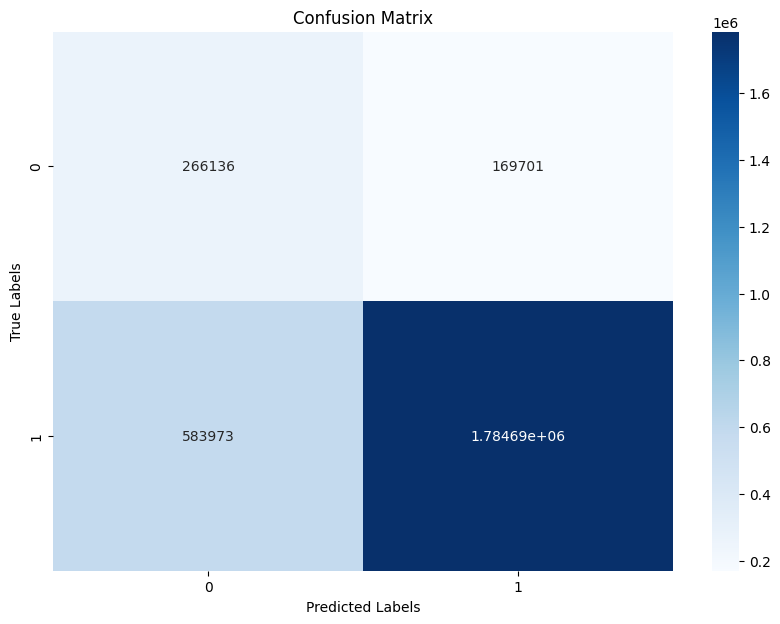

In [ ]:
confusion_matrix = metrics.confusionMatrix().toArray()

print(confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')  # 'g' formats numbers as integers
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()